In [29]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from itertools import combinations
from dataclasses import dataclass


In [30]:
#Config

seed = 42
#set_config(transform_output = "pandas")
sns.set_style("darkgrid")


# Load Data

In [31]:
nba       = pd.read_csv('../data/nba/nba_salaries.csv')
insurance = pd.read_csv('../data/insurance/insurance.csv')
airline   = pd.read_csv('../data/airline/train.csv')
airbnb    = pd.read_csv('../data/airbnb/listings.csv')

In [ ]:
@dataclass
class StatMeta:
    columns: list
    missing: float
    dtype: str
    unique_vals: int

def bivariate_stats(df: pd.DataFrame, target: str, round_to: int = 3):
    """
    Generate bivariate statistics between each feature and a target column in a DataFrame.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        target (str): Target column name.
        round_to (int): Decimal precision for rounded values.

    Returns:
        pd.DataFrame: Summary of statistics between each feature and the target.
    """
    columns = ['missing', 'type', 'unique_values', 'skew',
               'p_value', 'r', 'y = mx + b', 'spearman', 'spearman_pvalue', 
               'kendalltau', 'kendalltau_pvalue', 'chi2', 'ttest', 'F']
    output_df = pd.DataFrame(columns=columns)

    for feature in df:
        if feature == target:
            continue

        df_temp = df[[feature, target]].dropna()
        missing = round((len(df) - len(df_temp)) / len(df) * 100, round_to)
        dtype = df_temp[feature].dtype
        unique_vals = df_temp[feature].nunique()
        meta = StatMeta(columns, missing, dtype, unique_vals)

        if len(df_temp) < 2:
            output_df.loc[feature] = result_row(meta)
            continue
        
        # no variance = no stats
        if unique_vals == 1:
            output_df.loc[feature] = result_row(meta)
            continue

        if pd.api.types.is_numeric_dtype(df_temp[feature]) and pd.api.types.is_numeric_dtype(df_temp[target]):
            output_df.loc[feature] = handle_numeric_numeric(df_temp, feature, target, round_to, meta)
        elif not pd.api.types.is_numeric_dtype(df_temp[feature]) and not pd.api.types.is_numeric_dtype(df_temp[target]):
            output_df.loc[feature] = handle_categorical_categorical(df_temp, feature, target, round_to, meta)
        elif pd.api.types.is_numeric_dtype(df_temp[feature]) and df_temp[target].nunique() == 2:
            output_df.loc[feature] = handle_ttest(df_temp, feature, target, round_to, meta)
        elif pd.api.types.is_numeric_dtype(df_temp[target]) and df_temp[feature].nunique() == 2:
            output_df.loc[feature] = handle_ttest(df_temp, target, feature, round_to, meta, flip=True)
        elif is_invalid_categorical(df_temp, feature, target):
            output_df.loc[feature] = result_row(meta)
        elif pd.api.types.is_numeric_dtype(df_temp[feature]):
            output_df.loc[feature] = handle_anova(df_temp, feature, target, round_to, meta)
        else:
            output_df.loc[feature] = handle_anova(df_temp, target, feature, round_to, meta)

    return output_df

def result_row(meta: StatMeta, **kwargs):
    """
    Build a result row for the output DataFrame with provided statistics.

    Parameters:
        columns (list): All column headers for the output.
        missing (float): Percentage of missing data.
        dtype: Data type of the feature.
        unique_vals (int): Number of unique values.
        **kwargs: Additional statistic key-value pairs.

    Returns:
        dict: Row formatted with all required keys.
    """
    row = {col: '-' for col in meta.columns}
    row.update({
        'missing': f'{meta.missing}%',
        'type': meta.dtype,
        'unique values': meta.unique_vals
    })
    row.update(kwargs)
    return row

def handle_numeric_numeric(df_temp, feature, target, round_to, meta: StatMeta):
    """
    Compute correlations and regression line for numeric-numeric feature-target pairs.
    """
    linreg = stats.linregress(df_temp[feature], df_temp[target])
    spearman = stats.spearmanr(df_temp[feature], df_temp[target])
    kendall = stats.kendalltau(df_temp[feature], df_temp[target])
    return result_row(
        meta,
        skew=round(df_temp[feature].skew(), round_to),
        p_value=round(linreg.pvalue, round_to),
        r=round(linreg.rvalue, round_to),
        **{"y = mx + b": (
            f"y = {round(linreg.slope, round_to)}x + {round(linreg.intercept, round_to)}")},
        spearman=round(spearman.statistic, round_to),
        spearman_pvalue=round(spearman.pvalue, round_to),
        kendalltau=round(kendall.statistic, round_to),
        kendalltau_pvalue=round(kendall.pvalue, round_to)
    )

def handle_categorical_categorical(df_temp, feature, target, round_to, meta: StatMeta):
    """
    Compute Chi-squared test for categorical-categorical feature-target pairs.
    """
    chi2, p, _, _ = stats.chi2_contingency(pd.crosstab(df_temp[feature], df_temp[target]))
    return result_row(meta, p_value=round(p, round_to), chi2=round(chi2, round_to))

def handle_ttest(df_temp, numeric_col, cat_col, round_to, meta: StatMeta, flip=False):
    """
    Compute T-test for numeric-categorical feature-target pairs (binary categorical only).

    Parameters:
        flip (bool): Whether the roles of numeric and categorical columns are swapped.
    """
    unique = df_temp[cat_col].unique()
    group1 = df_temp[df_temp[cat_col] == unique[0]][numeric_col]
    group2 = df_temp[df_temp[cat_col] == unique[1]][numeric_col]
    tstat, p = stats.ttest_ind(group1, group2)
    skew = round(df_temp[numeric_col].skew(), round_to) if not flip else '-'
    return result_row(meta, p_value=round(p, round_to), ttest=round(tstat, round_to), skew=skew)

def handle_anova(df_temp, numeric_col, cat_col, round_to, meta: StatMeta):
    """
    Compute ANOVA for numeric-categorical pairs with more than two groups.
    """
    groups = [
        df_temp[df_temp[cat_col] == cat][numeric_col]
        for cat in df_temp[cat_col].unique()
    ]
    # Keep only groups with at least 2 samples
    valid_groups = [g for g in groups if len(g) >= 2]

    # check the number of valid groups
    if len(valid_groups) < 2:
        return result_row(meta)
    
    #if number of valid groups is 2, perform t-test
    if len(valid_groups) == 2:
        tstat, p = stats.ttest_ind(valid_groups[0], valid_groups[1])
        return result_row(
            meta,
            p_value=round(p, round_to),
            ttest=round(tstat, round_to),
            skew=round(df_temp[numeric_col].skew(), round_to),
        )
    
    try:
        # Perform ANOVA
        f, p = stats.f_oneway(*groups)
        return result_row(
            meta,
            p_value=round(p, round_to),
            F=round(f, round_to),
            skew=round(df_temp[numeric_col].skew(), round_to),
        )
    except ValueError as ve:
        # Handle specific ValueError exception
        print(f"ValueError: {ve}")  # Optional logging
        return result_row(meta)
    except TypeError as te:
        # Handle specific TypeError exception
        print(f"TypeError: {te}")  # Optional logging
        return result_row(meta)


def is_invalid_categorical(df_temp, feature, target):
    """
    Check whether both feature and target are non-numeric with all unique values.
    """
    return (not pd.api.types.is_numeric_dtype(df_temp[feature]) and df_temp[feature].nunique() == len(df_temp)) or \
           (not pd.api.types.is_numeric_dtype(df_temp[target]) and df_temp[target].nunique() == len(df_temp))


In [56]:
def criar_regression_plot(df: pd.DataFrame, column_1: str, column_2: str, round_to: int = 3):
    """
    Cria um gráfico de regressão linear entre duas colunas de um DataFrame.
    No gráfico griado será exibido a equação da reta, o valor de r e o p_value
    
    Parâmetros:
    df (pd.DataFrame): O DataFrame contendo os dados.
    column_1 (str): Nome da primeira coluna (eixo x).
    column_2 (str): Nome da segunda coluna (eixo y).
    round_to (int): Número de casas decimais para arredondar os resultados da regressão linear.
    
    Retorna:
    None
    """
    sns.regplot(data =df, x = column_1, y = column_2, line_kws = {'color' : 'darkorange'})
    #Pearson 
    result_lin_regression = stats.linregress(df[column_1], df[column_2])
    p_value = round(result_lin_regression.pvalue, round_to)
    r = round(result_lin_regression.rvalue, round_to)
    m = round(result_lin_regression.slope, round_to)
    b = round(result_lin_regression.intercept, round_to)

    #correlação spearmann
    res_spearman = stats.spearmanr(df[column_1], df[column_2])
    spearman = round(res_spearman.statistic, round_to)
    spearman_pvalue = round(res_spearman.pvalue, round_to)
    #kendalltau
    res_kendall = stats.kendalltau(df[column_1], df[column_2])
    kendalltau = round(res_kendall.statistic, round_to)
    kendalltau_pvalue = round(res_kendall.pvalue, round_to)

    skew_1 = round(df[column_1].skew(), round_to)
    skew_2 = round(df[column_2].skew(), round_to)

    text_str = f'y = {m}x + {b} \n'
    text_str += f'r = {r} \n'
    text_str += f'Pearson p_value = {p_value} \n'
    text_str += f'Skewness da feature {column_1}: {skew_1} \n'
    text_str += f'Skewness da feature {column_2}: {skew_2} \n'

    text_str += f'Spearman statistic: {spearman} \n'
    text_str += f'Spearman p value: {spearman_pvalue} \n'
    text_str += f'Kendall Tau statistic: {kendalltau} \n'
    text_str += f'Kendall Tau p value: {kendalltau_pvalue}'

    #O primeiro número controla a posição horizontal e o segundo a posição vertical
    #0.95 indica 95% da largura do gráfico. O texto será posicionada próximo ao final do grafico
    #0.2 indica que o texto ficará 20% acima da extremidade inferior do gráfico
    plt.text(0.95, 0.3, text_str, fontsize = 12, transform = plt.gcf().transFigure)
    plt.show()

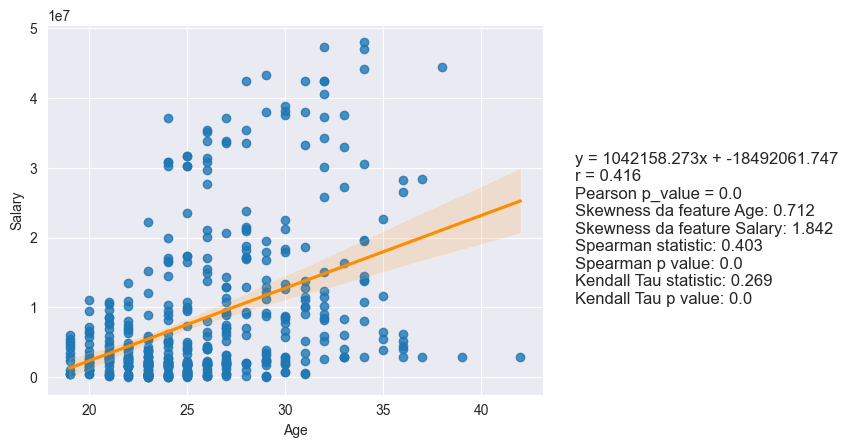

In [57]:
criar_regression_plot(nba, "Age", 'Salary')

In [ ]:
def criar_bar_plot(df: pd.DataFrame, numerical_feature: str, categorical_feature: str, round_to: int = 3, alpha = 0.05):
    """
    Cria um gráfico de barras entre uma feature numérica e uma categórica.
    
    Parâmetros:
    df (pd.DataFrame): O DataFrame contendo os dados.
    numeric_feature (str): Nome da feature numérica.
    categorical_feature (str): Nome da feature categórica.
    round_to (int): Número de casas decimais para arredondar os resultados do teste t.
    alpha (float): novel e significância
    
    Retorna:
    None
    """
    sns.barplot(data = df, x = categorical_feature, y = numerical_feature)
    
    #ttest para o caso da feature categórica ter duas classes
    if df[categorical_feature].nunique() == 2:
        feature_category_1 = df[df[categorical_feature] == df[categorical_feature].unique()[0]][numerical_feature]
        feature_category_2 = df[df[categorical_feature] == df[categorical_feature].unique()[1]][numerical_feature]
        ttest, p_value = stats.ttest_ind(feature_category_1, feature_category_2)
        ttest = round(ttest, round_to)
        p_value = round(p_value, round_to)

        text_str = 't-test: \n'
        text_str += f't statistic: {ttest} \n'
        text_str += f'p_value: {p_value} \n'
        plt.text(0.95, 0.2, text_str, fontsize = 12, transform = plt.gcf().transFigure)

    #F test para o caso da feature categórica ter mais de duas classes 
    else:
        groups_list = []
        for group in df[categorical_feature].unique():
            groups_list.append(df[df[categorical_feature] == group][numerical_feature])
        f_stat, p_value_f_test = stats.f_oneway(*groups_list)
        f_stat = round(f_stat, round_to)
        p_value_f_test = round(p_value_f_test, round_to)

        #Aplicar ttest para comparar pares de classes da feature categórica
        pair_classes = list(combinations(df[categorical_feature].unique(), 2)) #pares de classes que serão comparadas com o teste t
        num_pairs = len(pair_classes)
        bonferroni_correction = alpha / num_pairs #aplicação da correção de bonferroni para o nivel de sifgnificância estatítica
        bonferroni_correction = round(bonferroni_correction, round_to)
        ttest_pair_results = []
        for pair in pair_classes:
            feature_category_1 = df.loc[df[categorical_feature] == pair[0], numerical_feature]
            feature_category_2 = df.loc[df[categorical_feature] == pair[1], numerical_feature]
            ttest, p_value = stats.ttest_ind(feature_category_1, feature_category_2)
            ttest = round(ttest, round_to)
            p_value = round(p_value, round_to)
            result = f'{pair[0]} - {pair[1]} -> pvalue: {p_value}, ttest: {ttest}'
            ttest_pair_results.append(result) 

        text_str = 'anova: \n'
        text_str += f'F statistic: {f_stat} \n'
        text_str += f'p_value: {p_value_f_test} \n'
        text_str += 'ttest \n'
        text_str += f'Bonferroni correction: {bonferroni_correction} \n'
        for individiaul_result in ttest_pair_results:
            text_str += f'{individiaul_result} \n'
        plt.text(0.95, 0.2, text_str, fontsize = 12, transform = plt.gcf().transFigure)

    if df[categorical_feature].nunique() > 10:
        plt.xticks(rotation = 90)
    
    plt.show()

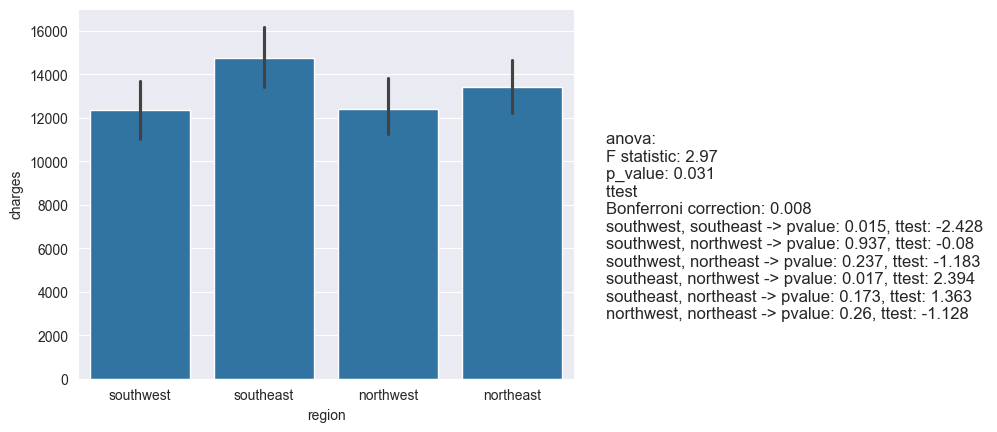

In [23]:
criar_bar_plot(insurance, 'charges', 'region')

In [7]:
classes = insurance['region'].unique()
classes

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [11]:
pairs = list(combinations(classes, 2))
pairs

[('southwest', 'southeast'),
 ('southwest', 'northwest'),
 ('southwest', 'northeast'),
 ('southeast', 'northwest'),
 ('southeast', 'northeast'),
 ('northwest', 'northeast')]

In [15]:
def criar_heat_map(df, categorical_feat_1, categorical_feat_2, axis_sum: int = None,round_to: int = 3):
    """
    Cria um gráfico de calor (heatmap) entre duas features categóricas.
    No heatmap será mostrado o total de samples e a proporção. A proporção poderá ser calculada em relação ao total, a soma das linha ou 
    das colunas
    
    Parâmetros:
    df (pd.DataFrame): O DataFrame contendo os dados.
    categorical_feat_1 (str): Nome da primeira feature categórica.
    categorical_feat_2 (str): Nome da segunda feature categórica.
    round_to (int): Número de casas decimais para arredondar os resultados do teste qui-quadrado.
    axis_sum: indica o eixo no qual os valores no heat map serão somados. A soma será usada para calcular 
              a proporção que será exibida no heat map
              Se axis_sum = None, será calculada a soma de todos os elementos no heat map. Então será exibida a propoção em relação ao total
              Se axis_sum = 1 será calculada a soma em relação ao eixo 1, então a proporção será calculada em relação ao total de elementos em uma mesma linha
              Se axis_sum = 0 será calculada a soma em relação ao eixo 0, então a propoção será calculada em relação ao total de elementos em uma mesma coluna
    
    Retorna:
    None
    """
    contingency_table = pd.crosstab(df[categorical_feat_1], df[categorical_feat_2])
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
    chi2 = round(chi2, round_to)
    p_value = round(p_value, round_to)

    text_str = 'Chi-squared test: \n'
    text_str += f'Chi-squared statistic: {chi2} \n'
    text_str += f'p_value: {p_value} \n'
   
    # Step 1: Calculate the total
    #Soma de total os elementos no heatmap
    if axis_sum is None:
        total = contingency_table.values.sum()

        # Step 2: Create custom labels: "count (xx.x%)"
        labels = np.empty_like(contingency_table.values, dtype=object)

        for i in range(contingency_table.shape[0]):
            for j in range(contingency_table.shape[1]):
                count = contingency_table.iloc[i, j]
                percent = count / total * 100
                labels[i, j] = f"{count}\n({percent:.1f}%)" #labels conterão a contagem e a proporção

    else: #claculo do total em relação a um dos eixos
        total = contingency_table.values.sum(axis = axis_sum)
        labels = np.empty_like(contingency_table.values, dtype=object)

        
        for i in range(contingency_table.shape[0]):
            for j in range(contingency_table.shape[1]):
                count = contingency_table.iloc[i, j]
                if axis_sum == 0: 
                    #para a soma em relação ao eixo 0, o número de elementos no resultado é igual ao número de colunas
                    percent = count / total[j] * 100
                elif axis_sum == 1:
                    #para a soma em relação ao eixo 1, o número de elementos no resultado é igual ao número de linhas
                    percent = count / total[i] * 100
                labels[i, j] = f"{count}\n({percent:.1f}%)"

    sns.heatmap(contingency_table, annot = labels, fmt = '', cmap = 'YlGnBu')
    plt.text(0.95, 0.2, text_str, fontsize = 12, transform = plt.gcf().transFigure)
    
    plt.show()

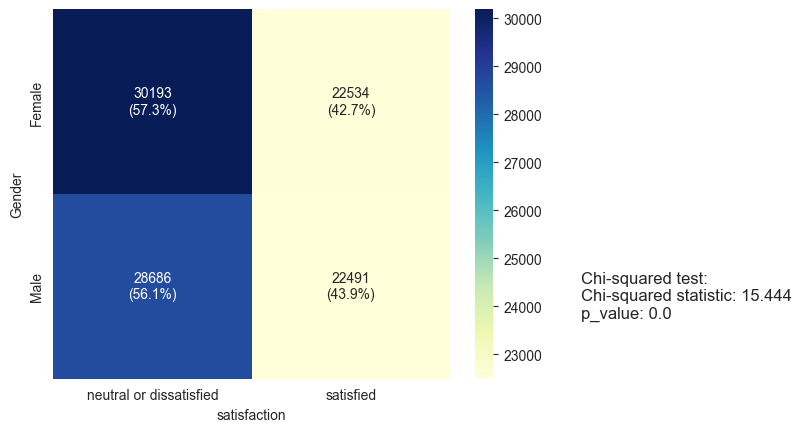

In [14]:
criar_heat_map(airline, 'Gender', 'satisfaction', axis_sum = 1)

In [162]:
contingency_table = pd.crosstab(airline['Gender'], airline['satisfaction'])

In [165]:
contingency_table

satisfaction,neutral or dissatisfied,satisfied
Gender,,
Female,30193,22534
Male,28686,22491


In [169]:
contingency_table.sum(axis=1).iloc[1]

np.int64(51177)